In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# === CONFIGURATION ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"  # Update as needed
OUTPUT_DIR = os.path.join(ROOT, "sync_plots_combined")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === HELPERS ===

def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

def extract_character_id(aname):
    return "_".join(aname.split("_")[:3])

def plot_combined_sync(df_dict, participant_id, char1, char2, sync_summary):
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    fig.suptitle(f"Participant {participant_id} — Rotation Synchrony (Chris ↔ Pawn)", fontsize=16)

    rotation_types = ['pitch', 'yaw', 'roll']
    body_parts = ['Head', 'WristLeft', 'WristRight']
    
    for row, body_part in enumerate(body_parts):
        for col, rot in enumerate(rotation_types):
            df1, df2 = df_dict[rot].get(body_part, (None, None))
            ax = axes[row][col]
            
            if df1 is None or df2 is None or df1.empty or df2.empty:
                ax.set_title(f"{body_part} {rot.capitalize()}: No Data")
                ax.axis("off")
                continue

            merged = pd.merge(df1, df2, on="time", suffixes=("_chris", "_pawn"))
            if merged.empty:
                ax.set_title(f"{body_part} {rot.capitalize()}: No Overlap")
                ax.axis("off")
                continue

            rot_chris = normalize(merged[f"rotation_{rot}_chris"])
            rot_pawn = normalize(merged[f"rotation_{rot}_pawn"])
            diff = np.abs(rot_chris - rot_pawn)
            in_sync = diff < 0.15
            sync_ratio = in_sync.sum() / len(in_sync) * 100

            ax.plot(merged["time"], rot_chris, label=f"{char1}", color="blue")
            ax.plot(merged["time"], rot_pawn, label=f"{char2}", color="orange")
            ax.fill_between(merged["time"], rot_chris, rot_pawn, where=in_sync, color="green", alpha=0.3)

            ax.set_title(f"{body_part} {rot.capitalize()} — {sync_ratio:.1f}% sync", fontsize=9)
            ax.grid(True)

            # Record for CSV summary
            sync_summary.append({
                "Participant": participant_id,
                "BodyPart": body_part,
                "Rotation": rot,
                "SyncPercent": round(sync_ratio, 2)
            })

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fname = f"{participant_id}_sync_combined.png"
    plt.savefig(os.path.join(OUTPUT_DIR, fname), dpi=300)
    plt.close()

# === STEP 1: LOAD PARTICIPANT DATA ===

participant_data = defaultdict(list)
print("🔍 Loading participants from Dublin and Lisbon...")

for location in os.listdir(ROOT):
    location_path = os.path.join(ROOT, location)
    if not os.path.isdir(location_path):
        continue

    for participant_id in os.listdir(location_path):
        participant_path = os.path.join(location_path, participant_id)
        heat_logs_path = os.path.join(participant_path, "heat_logs")
        if not os.path.exists(heat_logs_path):
            continue

        for session in os.listdir(heat_logs_path):
            session_path = os.path.join(heat_logs_path, session)
            if not os.path.isdir(session_path):
                continue

            csvs = [f for f in os.listdir(session_path) if f.endswith(".csv")]
            session_dfs = []
            for file in csvs:
                try:
                    df = pd.read_csv(os.path.join(session_path, file))
                    session_dfs.append(df)
                except:
                    continue

            if session_dfs:
                participant_data[participant_id].append(pd.concat(session_dfs, ignore_index=True))

print(f"✅ Loaded {len(participant_data)} participants\n")

# === STEP 2: ANALYZE SYNCHRONY ===

sync_summary = []

for participant_id, dfs in participant_data.items():
    print(f"📊 Processing Participant {participant_id} ...")
    full_df = pd.concat(dfs, ignore_index=True)

    required_cols = {"time", "rotation_pitch", "rotation_yaw", "rotation_roll", "Aname"}
    if not required_cols.issubset(full_df.columns):
        print(f"⚠️ Skipping {participant_id}: missing required columns.")
        continue

    full_df["char_id"] = full_df["Aname"].apply(extract_character_id)
    full_df["body_part"] = full_df["Aname"].apply(lambda x: x.split("_")[-1])
    characters = full_df["char_id"].unique()

    if len(characters) < 2:
        print(f"⚠️ Skipping {participant_id}: less than two characters.")
        continue

    # Identify Chris and Pawn
    if "Chris" in characters[0]:
        char1, char2 = characters[0], characters[1]
    elif "Chris" in characters[1]:
        char1, char2 = characters[1], characters[0]
    else:
        char1, char2 = characters[:2]  # fallback

    df_dict = {rot: {} for rot in ['pitch', 'yaw', 'roll']}
    for body_part in ['Head', 'WristLeft', 'WristRight']:
        for rot in ['pitch', 'yaw', 'roll']:
            rot_col = f"rotation_{rot}"
            df1 = full_df[(full_df["char_id"] == char1) & (full_df["body_part"] == body_part)][["time", rot_col]]
            df2 = full_df[(full_df["char_id"] == char2) & (full_df["body_part"] == body_part)][["time", rot_col]]

            df1 = df1.drop_duplicates("time").sort_values("time")
            df2 = df2.drop_duplicates("time").sort_values("time")
            df1 = df1.rename(columns={rot_col: f"{rot_col}_chris"})
            df2 = df2.rename(columns={rot_col: f"{rot_col}_pawn"})

            df_dict[rot][body_part] = (df1, df2)

    plot_combined_sync(df_dict, participant_id, char1, char2, sync_summary)

# === STEP 3: SAVE CSV SUMMARY ===

summary_df = pd.DataFrame(sync_summary)
csv_path = os.path.join(OUTPUT_DIR, "rotation_synchrony_summary.csv")
summary_df.to_csv(csv_path, index=False)
print(f"\n📄 Synchrony summary saved to {csv_path}")

# === STEP 4: BAR PLOT COMPARISON ===

plt.figure(figsize=(14, 6))
sns.barplot(data=summary_df, x="Participant", y="SyncPercent", hue="BodyPart")
plt.title("Rotation Synchrony % by Participant and Body Part")
plt.ylabel("% Time in Sync (Δ < 0.15)")
plt.xlabel("Participant")
plt.xticks(rotation=45)
plt.legend(title="Body Part")
plt.tight_layout()
bar_path = os.path.join(OUTPUT_DIR, "rotation_synchrony_comparison_chart.png")
plt.savefig(bar_path, dpi=300)
plt.close()
print(f"📊 Comparison chart saved to {bar_path}")


🔍 Loading participants from Dublin and Lisbon...
✅ Loaded 60 participants

📊 Processing Participant 1455 ...
📊 Processing Participant 1538 ...
📊 Processing Participant 1626 ...
📊 Processing Participant 1629 ...
📊 Processing Participant 1700 ...
📊 Processing Participant 1789 ...
📊 Processing Participant 1818 ...
📊 Processing Participant 2424 ...
📊 Processing Participant 2609 ...
📊 Processing Participant 3024 ...
📊 Processing Participant 3080 ...
📊 Processing Participant 3116 ...
📊 Processing Participant 3710 ...
📊 Processing Participant 3840 ...
📊 Processing Participant 3894 ...
📊 Processing Participant 4431 ...
📊 Processing Participant 4734 ...
📊 Processing Participant 4788 ...
📊 Processing Participant 4879 ...
📊 Processing Participant 5564 ...
📊 Processing Participant 5626 ...
📊 Processing Participant 5922 ...
📊 Processing Participant 6426 ...
📊 Processing Participant 6487 ...
📊 Processing Participant 6594 ...
📊 Processing Participant 6758 ...
📊 Processing Participant 6855 ...
📊 Proce

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# === CONFIGURATION ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"  # Adjust as needed
OUTPUT_DIR = os.path.join(ROOT, "sync_plots_combined")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === HELPER FUNCTIONS ===

def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

def extract_character_id(aname):
    return "_".join(aname.split("_")[:3])

def plot_combined_sync(df_dict, participant_id, char1, char2, sync_summary):
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    
    rotation_types = ['pitch', 'yaw', 'roll']
    body_parts = ['Head', 'WristLeft', 'WristRight']
    colors = {"Chris": "blue", "Pawn": "orange"}
    
    participant_syncs = []

    for row, body_part in enumerate(body_parts):
        for col, rot in enumerate(rotation_types):
            df1, df2 = df_dict[rot].get(body_part, (None, None))
            ax = axes[row][col]

            if df1 is None or df2 is None or df1.empty or df2.empty:
                ax.set_title(f"{body_part} {rot.capitalize()}: No Data", fontsize=9)
                ax.axis("off")
                continue

            merged = pd.merge(df1, df2, on="time", suffixes=("_chris", "_pawn"))
            if merged.empty:
                ax.set_title(f"{body_part} {rot.capitalize()}: No Overlap", fontsize=9)
                ax.axis("off")
                continue

            rot_chris = normalize(merged[f"rotation_{rot}_chris"])
            rot_pawn = normalize(merged[f"rotation_{rot}_pawn"])
            diff = np.abs(rot_chris - rot_pawn)
            in_sync = diff < 0.15
            sync_ratio = in_sync.sum() / len(in_sync) * 100
            participant_syncs.append(sync_ratio)

            ax.plot(merged["time"], rot_chris, label=f"{char1}", color=colors["Chris"])
            ax.plot(merged["time"], rot_pawn, label=f"{char2}", color=colors["Pawn"])
            ax.fill_between(merged["time"], rot_chris, rot_pawn, where=in_sync, color="green", alpha=0.3)

            ax.set_title(f"{body_part} {rot.capitalize()} — {sync_ratio:.1f}% Sync", fontsize=10)
            ax.grid(True)

            if col == 0:
                ax.set_ylabel("Normalized")
            if row == 2:
                ax.set_xlabel("Time")

            sync_summary.append({
                "Participant": participant_id,
                "BodyPart": body_part,
                "Rotation": rot,
                "SyncPercent": round(sync_ratio, 2)
            })

    # Average sync across all 9 plots
    avg_sync = np.mean(participant_syncs) if participant_syncs else 0
    fig.suptitle(
        f"Participant {participant_id} — Avg Sync: {avg_sync:.1f}% (Chris ↔ Pawn)",
        fontsize=16
    )

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(OUTPUT_DIR, f"{participant_id}_sync_combined.png"), dpi=300)
    plt.close()

# === LOAD AND PROCESS DATA ===

participant_data = defaultdict(list)
print("🔍 Scanning folder structure...")

for location in os.listdir(ROOT):
    location_path = os.path.join(ROOT, location)
    if not os.path.isdir(location_path):
        continue

    for participant_id in os.listdir(location_path):
        participant_path = os.path.join(location_path, participant_id)
        heat_logs_path = os.path.join(participant_path, "heat_logs")
        if not os.path.exists(heat_logs_path):
            continue

        for session in os.listdir(heat_logs_path):
            session_path = os.path.join(heat_logs_path, session)
            if not os.path.isdir(session_path):
                continue

            csv_files = [f for f in os.listdir(session_path) if f.endswith(".csv")]
            if not csv_files:
                continue

            session_dfs = []
            for file in csv_files:
                file_path = os.path.join(session_path, file)
                try:
                    df = pd.read_csv(file_path)
                    session_dfs.append(df)
                except Exception as e:
                    print(f"❌ Error reading {file_path}: {e}")

            if session_dfs:
                all_data = pd.concat(session_dfs, ignore_index=True)
                participant_data[participant_id].append(all_data)

print(f"\n✅ Found {len(participant_data)} participants with CSV data.\n")

# === ANALYZE SYNCHRONY ===

sync_summary = []

for participant_id, dfs in participant_data.items():
    print(f"📊 Processing Participant {participant_id} ...")

    full_df = pd.concat(dfs, ignore_index=True)

    required_cols = {"time", "rotation_pitch", "rotation_yaw", "rotation_roll", "Aname"}
    if not required_cols.issubset(full_df.columns):
        print(f"⚠️ Skipping {participant_id}: missing required columns.")
        continue

    full_df["char_id"] = full_df["Aname"].apply(extract_character_id)
    full_df["body_part"] = full_df["Aname"].apply(lambda x: x.split("_")[-1])
    characters = full_df["char_id"].unique()

    if len(characters) < 2:
        print(f"⚠️ Skipping {participant_id}: less than two characters.")
        continue

    # Try to assign Chris and Pawn labels (optional, can use default)
    char1, char2 = characters[:2]
    if "Chris" in char2:
        char1, char2 = char2, char1

    df_dict = {rot: {} for rot in ['pitch', 'yaw', 'roll']}
    for body_part in ['Head', 'WristLeft', 'WristRight']:
        for rot in ['pitch', 'yaw', 'roll']:
            rot_col = f"rotation_{rot}"
            df1 = full_df[(full_df["char_id"] == char1) & (full_df["body_part"] == body_part)][["time", rot_col]]
            df2 = full_df[(full_df["char_id"] == char2) & (full_df["body_part"] == body_part)][["time", rot_col]]

            df1 = df1.drop_duplicates("time").sort_values("time")
            df2 = df2.drop_duplicates("time").sort_values("time")

            df1 = df1.rename(columns={rot_col: f"{rot_col}_chris"})
            df2 = df2.rename(columns={rot_col: f"{rot_col}_pawn"})

            df_dict[rot][body_part] = (df1, df2)

    plot_combined_sync(df_dict, participant_id, char1, char2, sync_summary)

# === SAVE SYNCHRONY SUMMARY CSV ===

summary_df = pd.DataFrame(sync_summary)
csv_path = os.path.join(OUTPUT_DIR, "rotation_synchrony_summary.csv")
summary_df.to_csv(csv_path, index=False)
print(f"\n📄 Synchrony summary saved to {csv_path}")

# === PLOT BAR CHART COMPARISON ===

plt.figure(figsize=(14, 6))
sns.barplot(data=summary_df, x="Participant", y="SyncPercent", hue="BodyPart")
plt.title("Rotation Synchrony % by Participant and Body Part")
plt.ylabel("% Time in Sync (Δ < 0.15)")
plt.xlabel("Participant")
plt.xticks(rotation=45)
plt.legend(title="Body Part")
plt.tight_layout()
bar_path = os.path.join(OUTPUT_DIR, "rotation_synchrony_comparison_chart.png")
plt.savefig(bar_path, dpi=300)
plt.close()
print(f"📊 Bar chart saved to {bar_path}")


🔍 Scanning folder structure...

✅ Found 60 participants with CSV data.

📊 Processing Participant 1455 ...
📊 Processing Participant 1538 ...
📊 Processing Participant 1626 ...
📊 Processing Participant 1629 ...
📊 Processing Participant 1700 ...
📊 Processing Participant 1789 ...
📊 Processing Participant 1818 ...
📊 Processing Participant 2424 ...
📊 Processing Participant 2609 ...
📊 Processing Participant 3024 ...
📊 Processing Participant 3080 ...
📊 Processing Participant 3116 ...
📊 Processing Participant 3710 ...
📊 Processing Participant 3840 ...
📊 Processing Participant 3894 ...
📊 Processing Participant 4431 ...
📊 Processing Participant 4734 ...
📊 Processing Participant 4788 ...
📊 Processing Participant 4879 ...
📊 Processing Participant 5564 ...
📊 Processing Participant 5626 ...
📊 Processing Participant 5922 ...
📊 Processing Participant 6426 ...
📊 Processing Participant 6487 ...
📊 Processing Participant 6594 ...
📊 Processing Participant 6758 ...
📊 Processing Participant 6855 ...
📊 Processi

In [4]:
# Add per-participant average sync column
average_sync = summary_df.groupby("Participant")["SyncPercent"].mean().reset_index()
average_sync.columns = ["Participant", "AverageSync"]
summary_df = pd.merge(summary_df, average_sync, on="Participant")


In [5]:
average_sync.to_csv(os.path.join(OUTPUT_DIR, "average_sync_summary.csv"), index=False)


# Heatmaps where Participants are located from x, y, z coordinates.


📦 Scanning all participants...
📊 Processing Dublin_1455...
📊 Processing Dublin_1538...
📊 Processing Dublin_1626...
📊 Processing Dublin_1629...
📊 Processing Dublin_1700...
📊 Processing Dublin_1789...
📊 Processing Dublin_1818...
📊 Processing Dublin_2424...


ValueError: Contour levels must be increasing

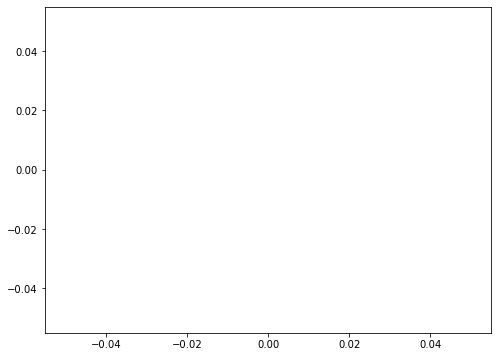

In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==== CONFIGURATION ====
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"
OUTPUT_DIR = os.path.join(ROOT, "location_heatmaps")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === HELPERS ===

def extract_character_id(aname):
    return "_".join(aname.split("_")[:3])  # e.g., myMRPawn_C_2147482403

def get_all_participants(data_root):
    all_participants = {}
    for location in os.listdir(data_root):
        loc_path = os.path.join(data_root, location)
        if not os.path.isdir(loc_path): continue

        for pid in os.listdir(loc_path):
            full_path = os.path.join(loc_path, pid, "heat_logs")
            if os.path.exists(full_path):
                all_participants[f"{location}_{pid}"] = full_path
    return all_participants

# === MAIN ===

print("📦 Scanning all participants...")
participants = get_all_participants(ROOT)

all_positions = []  # for global heatmap

for pid, heat_path in participants.items():
    print(f"📊 Processing {pid}...")
    dfs = []
    for session in os.listdir(heat_path):
        session_path = os.path.join(heat_path, session)
        if not os.path.isdir(session_path): continue

        for f in os.listdir(session_path):
            if not f.endswith(".csv"): continue
            file_path = os.path.join(session_path, f)
            try:
                df = pd.read_csv(file_path)
                if {"position_x", "position_y", "Aname"}.issubset(df.columns):
                    pawn_char = df["Aname"].str.contains("Pawn")
                    df = df[pawn_char]
                    dfs.append(df[["position_x", "position_y"]])
            except Exception as e:
                print(f"❌ Failed reading {file_path}: {e}")

    if dfs:
        combined = pd.concat(dfs, ignore_index=True)
        all_positions.append(combined)

        # Per-participant heatmap
        plt.figure(figsize=(8, 6))
        sns.kdeplot(
            data=combined,
            x="position_x",
            y="position_y",
            fill=True,
            cmap="mako",
            bw_adjust=0.3,
            levels=100,
            thresh=0.01
        )
        plt.title(f"Location Heatmap — {pid}")
        plt.xlabel("Position X")
        plt.ylabel("Position Y")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{pid}_location_heatmap.png"), dpi=300)
        plt.close()

# === GROUP LEVEL HEATMAP ===

if all_positions:
    print("\n🌍 Creating group-level heatmap...")
    global_df = pd.concat(all_positions, ignore_index=True)
    plt.figure(figsize=(10, 8))
    sns.kdeplot(
        data=global_df,
        x="position_x",
        y="position_y",
        fill=True,
        cmap="viridis",
        bw_adjust=0.3,
        levels=100,
        thresh=0.01
    )
    plt.title("Global Location Heatmap — All Participants")
    plt.xlabel("Position X")
    plt.ylabel("Position Y")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "all_participants_location_heatmap.png"), dpi=300)
    plt.close()

print(f"\n✅ Done! Heatmaps saved to:\n{OUTPUT_DIR}")



Heat map 3D coordinates 

# Heat map 3D coordinates

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# === CONFIG ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"
OUTPUT_DIR = os.path.join(ROOT, "location_heatmaps_3d")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def extract_character_id(aname):
    return "_".join(aname.split("_")[:3])

def get_all_participants(data_root):
    all_participants = {}
    for location in os.listdir(data_root):
        loc_path = os.path.join(data_root, location)
        if not os.path.isdir(loc_path): continue
        for pid in os.listdir(loc_path):
            full_path = os.path.join(loc_path, pid, "heat_logs")
            if os.path.exists(full_path):
                all_participants[f"{location}_{pid}"] = full_path
    return all_participants

def plot_3d_heatmap(df, pid):
    if df.shape[0] < 5:
        print(f"⚠️ Skipping {pid}: not enough data points for KDE.")
        return

    x = df['position_x']
    y = df['position_y']
    
    # Stack and check unique values
    xy = np.vstack([x, y])
    if np.unique(xy, axis=1).shape[1] < 5:
        print(f"⚠️ Skipping {pid}: not enough unique positions.")
        return

    # Compute KDE
    density = gaussian_kde(xy)(xy)

    # === PLOT ===
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(x, y, density, cmap='plasma', linewidth=0.1, antialiased=True)

    ax.set_title(f"3D Location Density — {pid}", fontsize=14)
    ax.set_xlabel("Position X")
    ax.set_ylabel("Position Y")
    ax.set_zlabel("Density")
    plt.tight_layout()

    out_path = os.path.join(OUTPUT_DIR, f"{pid}_3d_location.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"✅ 3D heatmap saved: {out_path}")

# === MAIN SCRIPT ===
print("📦 Scanning participants for 3D heatmaps...")
participants = get_all_participants(ROOT)
all_dfs = []

for pid, heat_path in participants.items():
    print(f"📊 Processing {pid}...")
    dfs = []

    for session in os.listdir(heat_path):
        session_path = os.path.join(heat_path, session)
        if not os.path.isdir(session_path): continue

        for f in os.listdir(session_path):
            if not f.endswith(".csv"): continue
            try:
                df = pd.read_csv(os.path.join(session_path, f))
                if {"position_x", "position_y", "Aname"}.issubset(df.columns):
                    df = df[df["Aname"].str.contains("Pawn")]
                    dfs.append(df[["position_x", "position_y"]])
            except Exception as e:
                print(f"❌ Error reading {f}: {e}")

    if dfs:
        combined = pd.concat(dfs, ignore_index=True).dropna()
        all_dfs.append(combined)
        plot_3d_heatmap(combined, pid)

# === Global Plot ===
if all_dfs:
    full_df = pd.concat(all_dfs, ignore_index=True).dropna()
    plot_3d_heatmap(full_df, "All_Participants")

print(f"\n✅ All heatmaps saved to: {OUTPUT_DIR}")



In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D

# === CONFIGURATION ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"  # Update as needed
OUTPUT_DIR = os.path.join(ROOT, "location_heatmaps_3d")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === HELPERS ===
def extract_character_id(aname):
    return "_".join(aname.split("_")[:3])

def get_all_participants(data_root):
    all_participants = {}
    for location in os.listdir(data_root):
        loc_path = os.path.join(data_root, location)
        if not os.path.isdir(loc_path): continue
        for pid in os.listdir(loc_path):
            heat_path = os.path.join(loc_path, pid, "heat_logs")
            if os.path.exists(heat_path):
                all_participants[f"{location}_{pid}"] = heat_path
    return all_participants

def plot_3d_heatmap(df, pid):
    x = df['position_x']
    y = df['position_y']
    
    # Compute 2D density estimate
    xy = np.vstack([x, y])
    density = gaussian_kde(xy)(xy)

    # === PLOT ===
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(x, y, density, cmap='plasma', linewidth=0.2, antialiased=True)

    ax.set_title(f"3D Location Density — {pid}", fontsize=14)
    ax.set_xlabel("Position X")
    ax.set_ylabel("Position Y")
    ax.set_zlabel("Density")

    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, f"{pid}_3d_location.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"✅ 3D heatmap saved: {out_path}")

# === MAIN SCRIPT ===
print("📦 Scanning all participants for heatmap data...")
participants = get_all_participants(ROOT)
global_dfs = []

for pid, heat_path in participants.items():
    dfs = []

    for session in os.listdir(heat_path):
        session_path = os.path.join(heat_path, session)
        if not os.path.isdir(session_path): continue

        for file in os.listdir(session_path):
            if not file.endswith(".csv"): continue
            try:
                fpath = os.path.join(session_path, file)
                df = pd.read_csv(fpath)
                if {"position_x", "position_y", "Aname"}.issubset(df.columns):
                    df = df[df["Aname"].str.contains("Pawn")]  # Only participant (not AI)
                    dfs.append(df[["position_x", "position_y"]])
            except Exception as e:
                print(f"⚠️ Error reading {file}: {e}")

    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True).dropna()
        global_dfs.append(combined_df)

# === Plot for All Participants Combined ===
if global_dfs:
    full_global_df = pd.concat(global_dfs, ignore_index=True).dropna()
    plot_3d_heatmap(full_global_df, "All_Participants")
else:
    print("❌ No valid participant location data found.")

print(f"\n✅ Done! All outputs saved in: {OUTPUT_DIR}")


📦 Scanning all participants for heatmap data...


In [46]:
def plot_3d_heatmap(df, pid):
    x = df['position_x']
    y = df['position_y']

    # KDE calculation
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    density = kde(xy)

    # Sort points by density for better surface plotting
    idx = density.argsort()
    x, y, density = x.iloc[idx], y.iloc[idx], density[idx]

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_trisurf(x, y, density, cmap='plasma', linewidth=0.2, antialiased=True)

    ax.set_title(f"🧍‍♂️ Global Location Density — {pid}", fontsize=16)
    ax.set_xlabel("Position X")
    ax.set_ylabel("Position Y")
    ax.set_zlabel("Density")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, f"{pid}_global_3d_location.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"✅ Global 3D heatmap saved: {out_path}")


In [44]:
def plot_2d_heatmap_with_contours(df, pid):
    x = df["position_x"].values
    y = df["position_y"].values

    # Grid for KDE
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(np.rot90(f), cmap='plasma', extent=[xmin, xmax, ymin, ymax])
    contour = plt.contour(xx, yy, f, levels=10, colors='black', linewidths=0.8)

    plt.colorbar(label="Density")
    plt.clabel(contour, inline=1, fontsize=8)
    plt.title(f"2D Location Heatmap with Contours — {pid}", fontsize=14)
    plt.xlabel("Position X")
    plt.ylabel("Position Y")
    plt.grid(True)
    plt.tight_layout()

    out_path = os.path.join(OUTPUT_DIR, f"{pid}_2d_location_contour.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"📊 2D contour heatmap saved: {out_path}")


# 3D Maps with AI character

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D  # noqa

# === CONFIGURATION ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"
OUTPUT_DIR = os.path.join(ROOT, "location_heatmaps_overlay_transparent")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === HELPERS ===

def extract_character_type(aname):
    if "Chris" in aname:
        return "Chris"
    elif "Pawn" in aname:
        return "Pawn"
    else:
        return "Other"

def get_all_participants(data_root):
    all_participants = {}
    for location in os.listdir(data_root):
        loc_path = os.path.join(data_root, location)
        if not os.path.isdir(loc_path): continue
        for pid in os.listdir(loc_path):
            full_path = os.path.join(loc_path, pid, "heat_logs")
            if os.path.exists(full_path):
                all_participants[f"{location}_{pid}"] = full_path
    return all_participants

def plot_3d_density_overlay(pawn_df, chris_df, pid):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    if not pawn_df.empty:
        pawn_xy = np.vstack([pawn_df['position_x'], pawn_df['position_y']])
        pawn_density = gaussian_kde(pawn_xy)(pawn_xy)
        ax.plot_trisurf(
            pawn_df['position_x'], pawn_df['position_y'], pawn_density,
            cmap='Blues', alpha=0.5, linewidth=0.1
        )

    if not chris_df.empty:
        chris_xy = np.vstack([chris_df['position_x'], chris_df['position_y']])
        chris_density = gaussian_kde(chris_xy)(chris_xy)
        ax.plot_trisurf(
            chris_df['position_x'], chris_df['position_y'], chris_density,
            cmap='Oranges', alpha=0.2, linewidth=0.1
        )

    ax.set_title(f"3D Location Overlay — {pid}", fontsize=14)
    ax.set_xlabel("Position X")
    ax.set_ylabel("Position Y")
    ax.set_zlabel("Density")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{pid}_3d_overlay_transparent.png"), dpi=300)
    plt.close()

# === MAIN ===

participants = get_all_participants(ROOT)
print("📦 Generating 3D overlays with transparency...")

for pid, heat_path in participants.items():
    pawn_dfs = []
    chris_dfs = []

    for session in os.listdir(heat_path):
        session_path = os.path.join(heat_path, session)
        if not os.path.isdir(session_path): continue

        for file in os.listdir(session_path):
            if not file.endswith(".csv"): continue
            file_path = os.path.join(session_path, file)
            try:
                df = pd.read_csv(file_path)
                if {"position_x", "position_y", "Aname"}.issubset(df.columns):
                    df["char_type"] = df["Aname"].apply(extract_character_type)
                    pawn_dfs.append(df[df["char_type"] == "Pawn"][["position_x", "position_y"]])
                    chris_dfs.append(df[df["char_type"] == "Chris"][["position_x", "position_y"]])
            except Exception as e:
                print(f"❌ Error reading {file_path}: {e}")

    if pawn_dfs or chris_dfs:
        pawn_df = pd.concat(pawn_dfs, ignore_index=True).dropna()
        chris_df = pd.concat(chris_dfs, ignore_index=True).dropna()
        plot_3d_density_overlay(pawn_df, chris_df, pid)

print(f"\n✅ Transparent 3D overlays saved in:\n{OUTPUT_DIR}")


📦 Generating 3D overlays with transparency...


#  Engagement Gaze

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# === CONFIGURATION ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"  # Adjust this
OUTPUT_DIR = os.path.join(ROOT, "gaze_engagement_plots")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === HELPERS ===
def extract_char_id(aname):
    return "_".join(aname.split("_")[:3])

def yaw_to_vector(yaw_deg):
    yaw_rad = np.radians(yaw_deg)
    return np.array([np.cos(yaw_rad), np.sin(yaw_rad)])

def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1) if np.linalg.norm(v1) != 0 else v1
    unit_v2 = v2 / np.linalg.norm(v2) if np.linalg.norm(v2) != 0 else v2
    dot = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
    angle_rad = np.arccos(dot)
    return np.degrees(angle_rad)

# === MAIN SCRIPT ===
print("🔍 Scanning participants...")

participant_data = defaultdict(list)

# Handle nested folders (e.g., Dublin/Lisbon)
for group_folder in os.listdir(ROOT):
    group_path = os.path.join(ROOT, group_folder)
    if not os.path.isdir(group_path):
        continue

    for participant_id in os.listdir(group_path):
        participant_path = os.path.join(group_path, participant_id)
        heat_logs_path = os.path.join(participant_path, "heat_logs")

        if not os.path.exists(heat_logs_path):
            continue

        for session_name in os.listdir(heat_logs_path):
            session_path = os.path.join(heat_logs_path, session_name)
            if not os.path.isdir(session_path):
                continue

            csvs = [f for f in os.listdir(session_path) if f.endswith(".csv")]
            dfs = []
            for csv_file in csvs:
                try:
                    df = pd.read_csv(os.path.join(session_path, csv_file))
                    dfs.append(df)
                except:
                    continue

            if dfs:
                combined = pd.concat(dfs, ignore_index=True)
                combined["group"] = group_folder
                participant_data[participant_id].append(combined)

print(f"✅ Loaded data from {len(participant_data)} participants.\n")

summary = []

for pid, df_list in participant_data.items():
    print(f"📊 Processing Participant {pid}...")
    df = pd.concat(df_list, ignore_index=True)
    if not {"time", "rotation_yaw", "position_x", "position_y", "Aname"}.issubset(df.columns):
        print(f"⚠️ Skipping {pid}: missing required columns.")
        continue

    df["char_id"] = df["Aname"].apply(extract_char_id)
    df["body_part"] = df["Aname"].apply(lambda x: x.split("_")[-1])
    characters = df["char_id"].unique()

    if len(characters) < 2:
        print(f"⚠️ Skipping {pid}: <2 characters.")
        continue

    # Identify Chris and Pawn
    chris_ids = df[df["Aname"].str.contains("Chris")]["char_id"].unique()
    if len(chris_ids) == 0:
        print(f"⚠️ Skipping {pid}: Chris not found.")
        continue

    char_chris = chris_ids[0]
    char_pawn = [cid for cid in characters if cid != char_chris][0]

    # Get head data
    df_chris = df[(df["char_id"] == char_chris) & (df["body_part"] == "Head")]
    df_pawn = df[(df["char_id"] == char_pawn) & (df["body_part"] == "Head")]

    df_chris = df_chris[["time", "position_x", "position_y"]].drop_duplicates("time")
    df_pawn = df_pawn[["time", "position_x", "position_y", "rotation_yaw"]].drop_duplicates("time")

    merged = pd.merge(df_pawn, df_chris, on="time", suffixes=("_pawn", "_chris"))
    if merged.empty:
        print(f"⚠️ No overlapping timestamps for {pid}.")
        continue

    gaze_flags = []

    for _, row in merged.iterrows():
        pawn_pos = np.array([row["position_x_pawn"], row["position_y_pawn"]])
        chris_pos = np.array([row["position_x_chris"], row["position_y_chris"]])
        yaw = row["rotation_yaw"]

        gaze_vector = yaw_to_vector(yaw)
        direction_to_chris = chris_pos - pawn_pos
        angle = angle_between(gaze_vector, direction_to_chris)

        is_looking = angle < 20
        gaze_flags.append(is_looking)

    merged["looking_at_chris"] = gaze_flags
    percent_looking = 100 * np.mean(gaze_flags)

    summary.append({
        "Participant": pid,
        "PercentLookingAtChris": round(percent_looking, 2)
    })

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(merged["time"], merged["rotation_yaw"], label="Pawn Head Yaw", color="orange")
    plt.fill_between(merged["time"], -180, 180,
                     where=merged["looking_at_chris"], color="green", alpha=0.3,
                     label="Looking at Chris (<20°)")
    plt.title(f"Participant {pid} — % Looking at Chris: {percent_looking:.1f}%")
    plt.xlabel("Time")
    plt.ylabel("Yaw Angle (°)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{pid}_gaze_engagement.png"), dpi=300)
    plt.close()

# Save summary CSV
summary_df = pd.DataFrame(summary)
summary_path = os.path.join(OUTPUT_DIR, "gaze_engagement_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"\n📄 Summary saved to {summary_path}")

# Optional: Bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="Participant", y="PercentLookingAtChris", color="steelblue")
plt.xticks(rotation=45)
plt.title("Percent of Time Pawn Looked at Chris")
plt.ylabel("Looking at Chris (%)")
plt.xlabel("Participant")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "gaze_engagement_bar_chart.png"), dpi=300)
plt.close()
print("📊 Bar chart saved.")


🔍 Scanning participants...
✅ Loaded data from 60 participants.

📊 Processing Participant 1455...
📊 Processing Participant 1538...
📊 Processing Participant 1626...
📊 Processing Participant 1629...
📊 Processing Participant 1700...
📊 Processing Participant 1789...
📊 Processing Participant 1818...
📊 Processing Participant 2424...
📊 Processing Participant 2609...
📊 Processing Participant 3024...
📊 Processing Participant 3080...
📊 Processing Participant 3116...
📊 Processing Participant 3710...
📊 Processing Participant 3840...
📊 Processing Participant 3894...
📊 Processing Participant 4431...
📊 Processing Participant 4734...
📊 Processing Participant 4788...
📊 Processing Participant 4879...
📊 Processing Participant 5564...
📊 Processing Participant 5626...
📊 Processing Participant 5922...
📊 Processing Participant 6426...
📊 Processing Participant 6487...
📊 Processing Participant 6594...
📊 Processing Participant 6758...
📊 Processing Participant 6855...
📊 Processing Participant 7150...
📊 Processing

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# === CONFIGURATION ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"  # Update as needed
OUTPUT_DIR = os.path.join(ROOT, "gaze_engagement_plots")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === HELPERS ===
def extract_char_id(aname):
    return "_".join(aname.split("_")[:3])

def yaw_to_vector(yaw_deg):
    yaw_rad = np.radians(yaw_deg)
    return np.array([np.cos(yaw_rad), np.sin(yaw_rad)])

def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1) if np.linalg.norm(v1) != 0 else v1
    unit_v2 = v2 / np.linalg.norm(v2) if np.linalg.norm(v2) != 0 else v2
    dot = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
    angle_rad = np.arccos(dot)
    return np.degrees(angle_rad)

# === MAIN SCRIPT ===
print("🔍 Scanning participants...")

participant_data = defaultdict(list)

# Handle nested folders (e.g., Dublin/Lisbon)
for group_folder in os.listdir(ROOT):
    group_path = os.path.join(ROOT, group_folder)
    if not os.path.isdir(group_path):
        continue

    for participant_id in os.listdir(group_path):
        participant_path = os.path.join(group_path, participant_id)
        heat_logs_path = os.path.join(participant_path, "heat_logs")

        if not os.path.exists(heat_logs_path):
            continue

        for session_name in os.listdir(heat_logs_path):
            session_path = os.path.join(heat_logs_path, session_name)
            if not os.path.isdir(session_path):
                continue

            csvs = [f for f in os.listdir(session_path) if f.endswith(".csv")]
            dfs = []
            for csv_file in csvs:
                try:
                    df = pd.read_csv(os.path.join(session_path, csv_file))
                    dfs.append(df)
                except:
                    continue

            if dfs:
                combined = pd.concat(dfs, ignore_index=True)
                combined["group"] = group_folder
                participant_data[participant_id].append(combined)

print(f"✅ Loaded data from {len(participant_data)} participants.\n")

summary = []

for pid, df_list in participant_data.items():
    print(f"📊 Processing Participant {pid}...")
    df = pd.concat(df_list, ignore_index=True)
    if not {"time", "rotation_yaw", "position_x", "position_y", "Aname"}.issubset(df.columns):
        print(f"⚠️ Skipping {pid}: missing required columns.")
        continue

    df["char_id"] = df["Aname"].apply(extract_char_id)
    df["body_part"] = df["Aname"].apply(lambda x: x.split("_")[-1])
    characters = df["char_id"].unique()

    if len(characters) < 2:
        print(f"⚠️ Skipping {pid}: <2 characters.")
        continue

    # Identify Chris and Pawn
    chris_ids = df[df["Aname"].str.contains("Chris")]["char_id"].unique()
    if len(chris_ids) == 0:
        print(f"⚠️ Skipping {pid}: Chris not found.")
        continue

    char_chris = chris_ids[0]
    char_pawn = [cid for cid in characters if cid != char_chris][0]

    # Get head data
    df_chris = df[(df["char_id"] == char_chris) & (df["body_part"] == "Head")]
    df_pawn = df[(df["char_id"] == char_pawn) & (df["body_part"] == "Head")]

    df_chris = df_chris[["time", "position_x", "position_y"]].drop_duplicates("time")
    df_pawn = df_pawn[["time", "position_x", "position_y", "rotation_yaw"]].drop_duplicates("time")

    merged = pd.merge(df_pawn, df_chris, on="time", suffixes=("_pawn", "_chris"))
    if merged.empty:
        print(f"⚠️ No overlapping timestamps for {pid}.")
        continue

    gaze_flags = []

    for _, row in merged.iterrows():
        pawn_pos = np.array([row["position_x_pawn"], row["position_y_pawn"]])
        chris_pos = np.array([row["position_x_chris"], row["position_y_chris"]])
        yaw = row["rotation_yaw"]

        gaze_vector = yaw_to_vector(yaw)
        direction_to_chris = chris_pos - pawn_pos
        angle = angle_between(gaze_vector, direction_to_chris)

        is_looking = angle < 20
        gaze_flags.append(is_looking)

    merged["looking_at_chris"] = gaze_flags
    percent_looking = 100 * np.mean(gaze_flags)

    summary.append({
        "Participant": pid,
        "PercentLookingAtChris": round(percent_looking, 2)
    })

    # === PLOT with label ===
    plt.figure(figsize=(10, 4))
    plt.plot(merged["time"], merged["rotation_yaw"], label="Pawn Head Yaw", color="orange")
    plt.fill_between(merged["time"], -180, 180,
                     where=merged["looking_at_chris"], color="green", alpha=0.3,
                     label="Looking at Chris (<20°)")
    plt.title(f"Participant {pid} — Head Yaw vs Gaze Engagement")
    plt.xlabel("Time")
    plt.ylabel("Yaw Angle (°)")
    plt.grid(True)
    plt.legend()

    # Add percentage text label
    text_label = f"{percent_looking:.1f}% Looking at Chris"
    plt.text(0.02, 0.95, text_label, transform=plt.gca().transAxes,
             fontsize=12, color='green', weight='bold', bbox=dict(facecolor='white', alpha=0.6))

    plt.tight_layout()
    plot_path = os.path.join(OUTPUT_DIR, f"{pid}_gaze_engagement.png")
    plt.savefig(plot_path, dpi=300)
    plt.close()

# === SUMMARY CSV ===
summary_df = pd.DataFrame(summary)
summary_path = os.path.join(OUTPUT_DIR, "gaze_engagement_summary.csv")
summary_df.to_csv(summary_path, index=False)
print(f"\n📄 Gaze summary saved to {summary_path}")

# === BAR CHART ===
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df.sort_values("PercentLookingAtChris", ascending=False),
            x="Participant", y="PercentLookingAtChris", color="steelblue")
plt.title("Participant Gaze Toward Chris (%)")
plt.ylabel("Looking at Chris (%)")
plt.xlabel("Participant")
plt.xticks(rotation=45)
plt.tight_layout()
bar_path = os.path.join(OUTPUT_DIR, "gaze_engagement_bar_chart.png")
plt.savefig(bar_path, dpi=300)
plt.close()
print("📊 Bar chart saved.")


🔍 Scanning participants...
✅ Loaded data from 60 participants.

📊 Processing Participant 1455...
📊 Processing Participant 1538...
📊 Processing Participant 1626...
📊 Processing Participant 1629...
📊 Processing Participant 1700...
📊 Processing Participant 1789...
📊 Processing Participant 1818...
📊 Processing Participant 2424...
📊 Processing Participant 2609...
📊 Processing Participant 3024...
📊 Processing Participant 3080...
📊 Processing Participant 3116...
📊 Processing Participant 3710...
📊 Processing Participant 3840...
📊 Processing Participant 3894...
📊 Processing Participant 4431...
📊 Processing Participant 4734...
📊 Processing Participant 4788...
📊 Processing Participant 4879...
📊 Processing Participant 5564...
📊 Processing Participant 5626...
📊 Processing Participant 5922...
📊 Processing Participant 6426...
📊 Processing Participant 6487...
📊 Processing Participant 6594...
📊 Processing Participant 6758...
📊 Processing Participant 6855...
📊 Processing Participant 7150...
📊 Processing

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\bmoha\\Desktop\\DataCollection\\gaze_engagement_plots\\gaze_engagement_summary.csv'

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# === CONFIGURATION ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"  # Update if needed
OUTPUT_DIR = os.path.join(ROOT, "gaze_engagement_plots")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === HELPERS ===
def extract_char_id(aname):
    return "_".join(aname.split("_")[:3])

def yaw_to_vector(yaw_deg):
    yaw_rad = np.radians(yaw_deg)
    return np.array([np.cos(yaw_rad), np.sin(yaw_rad)])

def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1) if np.linalg.norm(v1) != 0 else v1
    unit_v2 = v2 / np.linalg.norm(v2) if np.linalg.norm(v2) != 0 else v2
    dot = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
    angle_rad = np.arccos(dot)
    return np.degrees(angle_rad)

# === LOAD PARTICIPANT DATA ===
print("🔍 Scanning participants...")

participant_data = defaultdict(list)

# Nested structure: e.g., Dublin/1455/heat_logs/...
for group_folder in os.listdir(ROOT):
    group_path = os.path.join(ROOT, group_folder)
    if not os.path.isdir(group_path):
        continue

    for participant_id in os.listdir(group_path):
        participant_path = os.path.join(group_path, participant_id)
        heat_logs_path = os.path.join(participant_path, "heat_logs")

        if not os.path.exists(heat_logs_path):
            continue

        for session_name in os.listdir(heat_logs_path):
            session_path = os.path.join(heat_logs_path, session_name)
            if not os.path.isdir(session_path):
                continue

            csvs = [f for f in os.listdir(session_path) if f.endswith(".csv")]
            dfs = []
            for csv_file in csvs:
                try:
                    df = pd.read_csv(os.path.join(session_path, csv_file))
                    dfs.append(df)
                except:
                    continue

            if dfs:
                combined = pd.concat(dfs, ignore_index=True)
                combined["group"] = group_folder
                participant_data[participant_id].append(combined)

print(f"✅ Loaded data from {len(participant_data)} participants.\n")

# === ANALYZE GAZE ===
summary = []

for pid, df_list in participant_data.items():
    print(f"📊 Processing Participant {pid}...")
    df = pd.concat(df_list, ignore_index=True)

    if not {"time", "rotation_yaw", "position_x", "position_y", "Aname"}.issubset(df.columns):
        print(f"⚠️ Skipping {pid}: missing required columns.")
        continue

    df["char_id"] = df["Aname"].apply(extract_char_id)
    df["body_part"] = df["Aname"].apply(lambda x: x.split("_")[-1])
    characters = df["char_id"].unique()

    if len(characters) < 2:
        print(f"⚠️ Skipping {pid}: <2 characters.")
        continue

    # Identify Chris and Pawn
    chris_ids = df[df["Aname"].str.contains("Chris")]["char_id"].unique()
    if len(chris_ids) == 0:
        print(f"⚠️ Skipping {pid}: Chris not found.")
        continue

    char_chris = chris_ids[0]
    char_pawn = [cid for cid in characters if cid != char_chris][0]

    # Get HEAD data for Chris and Pawn
    df_chris = df[(df["char_id"] == char_chris) & (df["body_part"] == "Head")]
    df_pawn = df[(df["char_id"] == char_pawn) & (df["body_part"] == "Head")]

    df_chris = df_chris[["time", "position_x", "position_y"]].drop_duplicates("time")
    df_pawn = df_pawn[["time", "position_x", "position_y", "rotation_yaw"]].drop_duplicates("time")

    merged = pd.merge(df_pawn, df_chris, on="time", suffixes=("_pawn", "_chris"))
    if merged.empty:
        print(f"⚠️ No overlapping timestamps for {pid}.")
        continue

    gaze_flags = []
    for _, row in merged.iterrows():
        pawn_pos = np.array([row["position_x_pawn"], row["position_y_pawn"]])
        chris_pos = np.array([row["position_x_chris"], row["position_y_chris"]])
        yaw = row["rotation_yaw"]

        gaze_vector = yaw_to_vector(yaw)
        direction_to_chris = chris_pos - pawn_pos
        angle = angle_between(gaze_vector, direction_to_chris)

        is_looking = angle < 20
        gaze_flags.append(is_looking)

    merged["looking_at_chris"] = gaze_flags
    percent_looking = 100 * np.mean(gaze_flags)

    # Time stats
    interaction_start = merged["time"].min()
    interaction_end = merged["time"].max()
    interaction_duration = interaction_end - interaction_start
    total_frames = len(merged)

    summary.append({
        "Participant": pid,
        "PercentLookingAtChris": round(percent_looking, 2),
        "TotalFramesCompared": total_frames,
        "TimeStart": round(interaction_start, 3),
        "TimeEnd": round(interaction_end, 3),
        "InteractionDurationSeconds": round(interaction_duration, 2)
    })

    # === PLOT ===
    plt.figure(figsize=(10, 4))
    plt.plot(merged["time"], merged["rotation_yaw"], label="Pawn Head Yaw", color="orange")
    plt.fill_between(merged["time"], -180, 180,
                     where=merged["looking_at_chris"], color="green", alpha=0.3,
                     label="Looking at Chris (<20°)")
    plt.title(f"Participant {pid} — Head Yaw vs Gaze Engagement")
    plt.xlabel("Time (s)")
    plt.ylabel("Yaw Angle (°)")
    plt.grid(True)
    plt.legend()

    # Add % label
    plt.text(0.02, 0.95, f"{percent_looking:.1f}% Looking at Chris",
             transform=plt.gca().transAxes,
             fontsize=12, color='green', weight='bold',
             bbox=dict(facecolor='white', alpha=0.6))

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{pid}_gaze_engagement.png"), dpi=300)
    plt.close()

# === SAVE SUMMARY CSV ===
summary_df = pd.DataFrame(summary)
csv_path = os.path.join(OUTPUT_DIR, "gaze_engagement_summary.csv")
summary_df.to_csv(csv_path, index=False)
print(f"\n📄 Summary saved to: {csv_path}")

# === COMPARISON BAR CHART ===
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df.sort_values("PercentLookingAtChris", ascending=False),
            x="Participant", y="PercentLookingAtChris", color="skyblue")
plt.title("Participant Gaze Toward Chris (%)")
plt.ylabel("Looking at Chris (%)")
plt.xlabel("Participant")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "gaze_engagement_bar_chart.png"), dpi=300)
plt.close()
print("📊 Bar chart saved.")


🔍 Scanning participants...
✅ Loaded data from 60 participants.

📊 Processing Participant 1455...
📊 Processing Participant 1538...
📊 Processing Participant 1626...
📊 Processing Participant 1629...
📊 Processing Participant 1700...
📊 Processing Participant 1789...
📊 Processing Participant 1818...
📊 Processing Participant 2424...
📊 Processing Participant 2609...
📊 Processing Participant 3024...
📊 Processing Participant 3080...
📊 Processing Participant 3116...
📊 Processing Participant 3710...
📊 Processing Participant 3840...
📊 Processing Participant 3894...
📊 Processing Participant 4431...
📊 Processing Participant 4734...
📊 Processing Participant 4788...
📊 Processing Participant 4879...
📊 Processing Participant 5564...
📊 Processing Participant 5626...
📊 Processing Participant 5922...
📊 Processing Participant 6426...
📊 Processing Participant 6487...
📊 Processing Participant 6594...
📊 Processing Participant 6758...
📊 Processing Participant 6855...
📊 Processing Participant 7150...
📊 Processing

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# === CONFIGURATION ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"
OUTPUT_DIR = os.path.join(ROOT, "gaze_engagement_streaks")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === HELPERS ===
def extract_char_id(aname):
    return "_".join(aname.split("_")[:3])

def yaw_to_vector(yaw_deg):
    yaw_rad = np.radians(yaw_deg)
    return np.array([np.cos(yaw_rad), np.sin(yaw_rad)])

def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1) if np.linalg.norm(v1) != 0 else v1
    unit_v2 = v2 / np.linalg.norm(v2) if np.linalg.norm(v2) != 0 else v2
    dot = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
    angle_rad = np.arccos(dot)
    return np.degrees(angle_rad)

# === LOAD DATA ===
print("🔍 Loading participant data...")
participant_data = defaultdict(list)

for group_folder in os.listdir(ROOT):
    group_path = os.path.join(ROOT, group_folder)
    if not os.path.isdir(group_path):
        continue

    for participant_id in os.listdir(group_path):
        participant_path = os.path.join(group_path, participant_id)
        heat_logs_path = os.path.join(participant_path, "heat_logs")
        if not os.path.exists(heat_logs_path):
            continue

        for session in os.listdir(heat_logs_path):
            session_path = os.path.join(heat_logs_path, session)
            if not os.path.isdir(session_path):
                continue

            csvs = [f for f in os.listdir(session_path) if f.endswith(".csv")]
            dfs = []
            for f in csvs:
                try:
                    df = pd.read_csv(os.path.join(session_path, f))
                    dfs.append(df)
                except:
                    continue

            if dfs:
                combined = pd.concat(dfs, ignore_index=True)
                combined["group"] = group_folder
                participant_data[participant_id].append(combined)

print(f"✅ Loaded data from {len(participant_data)} participants.\n")

# === PROCESSING GAZE STREAKS ===
all_streaks = []
streak_summary = []

def find_streaks(times, flags):
    streaks = []
    current_streak = []
    for t, flag in zip(times, flags):
        if flag:
            current_streak.append(t)
        elif current_streak:
            streaks.append((current_streak[0], current_streak[-1]))
            current_streak = []
    if current_streak:
        streaks.append((current_streak[0], current_streak[-1]))
    return streaks

for pid, dfs in participant_data.items():
    print(f"📊 Processing {pid}...")
    df = pd.concat(dfs, ignore_index=True)

    if not {"time", "rotation_yaw", "position_x", "position_y", "Aname"}.issubset(df.columns):
        print(f"⚠️ Skipping {pid}: missing columns.")
        continue

    df["char_id"] = df["Aname"].apply(extract_char_id)
    df["body_part"] = df["Aname"].apply(lambda x: x.split("_")[-1])
    characters = df["char_id"].unique()

    if len(characters) < 2:
        print(f"⚠️ Skipping {pid}: <2 characters.")
        continue

    chris_ids = df[df["Aname"].str.contains("Chris")]["char_id"].unique()
    if len(chris_ids) == 0:
        print(f"⚠️ Skipping {pid}: Chris not found.")
        continue

    char_chris = chris_ids[0]
    char_pawn = [cid for cid in characters if cid != char_chris][0]

    df_chris = df[(df["char_id"] == char_chris) & (df["body_part"] == "Head")]
    df_pawn = df[(df["char_id"] == char_pawn) & (df["body_part"] == "Head")]

    df_chris = df_chris[["time", "position_x", "position_y"]].drop_duplicates("time")
    df_pawn = df_pawn[["time", "position_x", "position_y", "rotation_yaw"]].drop_duplicates("time")

    merged = pd.merge(df_pawn, df_chris, on="time", suffixes=("_pawn", "_chris"))
    if merged.empty:
        continue

    looking_flags = []
    for _, row in merged.iterrows():
        pawn_pos = np.array([row["position_x_pawn"], row["position_y_pawn"]])
        chris_pos = np.array([row["position_x_chris"], row["position_y_chris"]])
        yaw = row["rotation_yaw"]
        gaze_vec = yaw_to_vector(yaw)
        dir_to_chris = chris_pos - pawn_pos
        angle = angle_between(gaze_vec, dir_to_chris)
        looking_flags.append(angle < 20)

    merged["looking_at_chris"] = looking_flags
    streaks = find_streaks(merged["time"].values, looking_flags)

    for i, (start, end) in enumerate(streaks):
        all_streaks.append({
            "Participant": pid,
            "StreakID": i + 1,
            "GazeStartTime": round(start, 3),
            "GazeEndTime": round(end, 3),
            "GazeDuration": round(end - start, 3)
        })

    if streaks:
        durations = [end - start for start, end in streaks]
        avg_dur = np.mean(durations)
        longest = np.max(durations)
        streak_summary.append({
            "Participant": pid,
            "NumStreaks": len(streaks),
            "TotalGazeTime": round(np.sum(durations), 2),
            "AverageGazeDuration": round(avg_dur, 2),
            "LongestStreak": round(longest, 2)
        })

        # === PLOT ===
        plt.figure(figsize=(10, 2))
        for s, e in streaks:
            plt.axvspan(s, e, color="green", alpha=0.5)
        plt.title(f"{pid} — Gaze Streaks (Avg. Duration = {avg_dur:.2f}s)")
        plt.xlabel("Time (s)")
        plt.yticks([])
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{pid}_gaze_streaks.png"), dpi=300)
        plt.close()

# === SAVE OUTPUT ===
df_streaks = pd.DataFrame(all_streaks)
df_summary = pd.DataFrame(streak_summary)

df_streaks.to_csv(os.path.join(OUTPUT_DIR, "gaze_streaks.csv"), index=False)
df_summary.to_csv(os.path.join(OUTPUT_DIR, "gaze_streaks_summary.csv"), index=False)

print("\n✅ Saved:")
print("• Gaze episodes → gaze_streaks.csv")
print("• Summary stats → gaze_streaks_summary.csv")
print("• Visual plots per participant")


🔍 Loading participant data...
✅ Loaded data from 60 participants.

📊 Processing 1455...
📊 Processing 1538...
📊 Processing 1626...
📊 Processing 1629...
📊 Processing 1700...
📊 Processing 1789...
📊 Processing 1818...
📊 Processing 2424...
📊 Processing 2609...
📊 Processing 3024...
📊 Processing 3080...
📊 Processing 3116...
📊 Processing 3710...
📊 Processing 3840...
📊 Processing 3894...
📊 Processing 4431...
📊 Processing 4734...
📊 Processing 4788...
📊 Processing 4879...
📊 Processing 5564...
📊 Processing 5626...
📊 Processing 5922...
📊 Processing 6426...
📊 Processing 6487...
📊 Processing 6594...
📊 Processing 6758...
📊 Processing 6855...
📊 Processing 7150...
📊 Processing 7343...
📊 Processing 7395...
📊 Processing 7487...
📊 Processing 8109...
📊 Processing 8342...
📊 Processing 8851...
📊 Processing 8985...
📊 Processing 9296...
📊 Processing 1060...
📊 Processing 2150...
📊 Processing 2182...
📊 Processing 2226...
📊 Processing 2462...
📊 Processing 2973...
⚠️ Skipping 2973: <2 characters.
📊 Processing 3154.

✅ DTW Distance for 1455 — WristRight: 879241.35


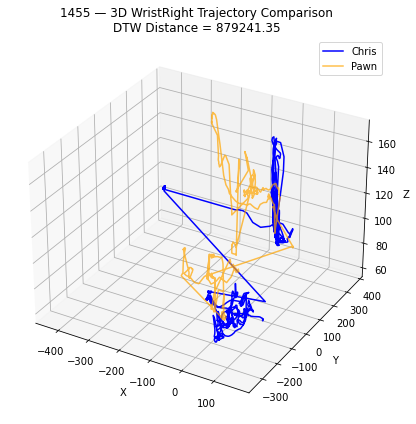

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# === CONFIG ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"
PARTICIPANT_ID = "1455"  # Change this to any specific participant
HAND = "WristRight"
OUTPUT_DIR = os.path.join(ROOT, "hand_dtw_motion")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def extract_char_id(aname):
    return "_".join(aname.split("_")[:3])

# === Load Data ===
def load_participant_data(pid):
    for group in os.listdir(ROOT):
        group_path = os.path.join(ROOT, group)
        if not os.path.isdir(group_path):
            continue
        participant_path = os.path.join(group_path, pid)
        heat_logs_path = os.path.join(participant_path, "heat_logs")
        if not os.path.exists(heat_logs_path):
            continue

        dfs = []
        for session in os.listdir(heat_logs_path):
            session_path = os.path.join(heat_logs_path, session)
            if not os.path.isdir(session_path):
                continue
            for file in os.listdir(session_path):
                if file.endswith(".csv"):
                    try:
                        df = pd.read_csv(os.path.join(session_path, file))
                        dfs.append(df)
                    except:
                        continue
        if dfs:
            return pd.concat(dfs, ignore_index=True)
    return None

# === Load + Preprocess ===
df = load_participant_data(PARTICIPANT_ID)
if df is None:
    print(f"❌ No data found for {PARTICIPANT_ID}")
    exit()

required_cols = {"time", "position_x", "position_y", "position_z", "Aname"}
if not required_cols.issubset(df.columns):
    print("❌ Missing required columns.")
    exit()

df["char_id"] = df["Aname"].apply(extract_char_id)
df["body_part"] = df["Aname"].apply(lambda x: x.split("_")[-1])
char_ids = df["char_id"].unique()

# Identify characters
chris_ids = df[df["Aname"].str.contains("Chris")]["char_id"].unique()
if len(chris_ids) == 0:
    print(f"❌ Chris not found for {PARTICIPANT_ID}")
    exit()

char_chris = chris_ids[0]
char_pawn = [c for c in char_ids if c != char_chris][0]

# === Extract hand motion data ===
def extract_hand_trajectory(df, char_id, hand):
    d = df[(df["char_id"] == char_id) & (df["body_part"] == hand)]
    d = d[["time", "position_x", "position_y", "position_z"]].drop_duplicates("time").sort_values("time")
    return d

df_chris = extract_hand_trajectory(df, char_chris, HAND)
df_pawn = extract_hand_trajectory(df, char_pawn, HAND)

# === Merge and align by time ===
merged = pd.merge(df_chris, df_pawn, on="time", suffixes=("_chris", "_pawn"))
if merged.empty:
    print(f"❌ No overlapping data for {PARTICIPANT_ID}")
    exit()

# Create 3D sequences
chris_xyz = merged[["position_x_chris", "position_y_chris", "position_z_chris"]].values
pawn_xyz = merged[["position_x_pawn", "position_y_pawn", "position_z_pawn"]].values

# === Compute DTW ===


# Computes DTW distance using default (Euclidean) distance
dtw_distance, path = fastdtw(chris_xyz, pawn_xyz, dist=euclidean)


print(f"✅ DTW Distance for {PARTICIPANT_ID} — {HAND}: {dtw_distance:.2f}")

# === Plot Trajectories ===
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(chris_xyz[:, 0], chris_xyz[:, 1], chris_xyz[:, 2], label='Chris', color='blue')
ax.plot(pawn_xyz[:, 0], pawn_xyz[:, 1], pawn_xyz[:, 2], label='Pawn', color='orange', alpha=0.7)

ax.set_title(f"{PARTICIPANT_ID} — 3D {HAND} Trajectory Comparison\nDTW Distance = {dtw_distance:.2f}")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"{PARTICIPANT_ID}_{HAND}_DTW.png"), dpi=300)
plt.show()


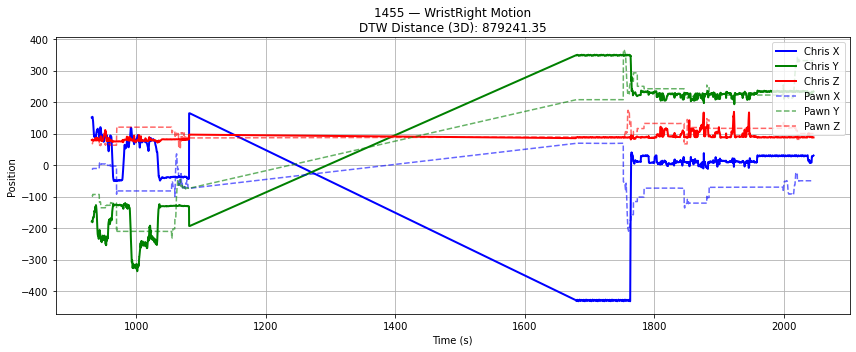

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
time = merged["time"]

# Plot Chris’s 3D motion
ax.plot(time, merged["position_x_chris"], label="Chris X", color="blue", linewidth=2)
ax.plot(time, merged["position_y_chris"], label="Chris Y", color="green", linewidth=2)
ax.plot(time, merged["position_z_chris"], label="Chris Z", color="red", linewidth=2)

# Plot Pawn’s 3D motion (same colors, dashed)
ax.plot(time, merged["position_x_pawn"], label="Pawn X", color="blue", linestyle="--", alpha=0.6)
ax.plot(time, merged["position_y_pawn"], label="Pawn Y", color="green", linestyle="--", alpha=0.6)
ax.plot(time, merged["position_z_pawn"], label="Pawn Z", color="red", linestyle="--", alpha=0.6)

ax.set_title(f"{PARTICIPANT_ID} — WristRight Motion\nDTW Distance (3D): {dtw_distance:.2f}")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position")
ax.legend(loc="upper right")
ax.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"{PARTICIPANT_ID}_WristRight_DTW_OverlayPlot.png"), dpi=300)
plt.show()


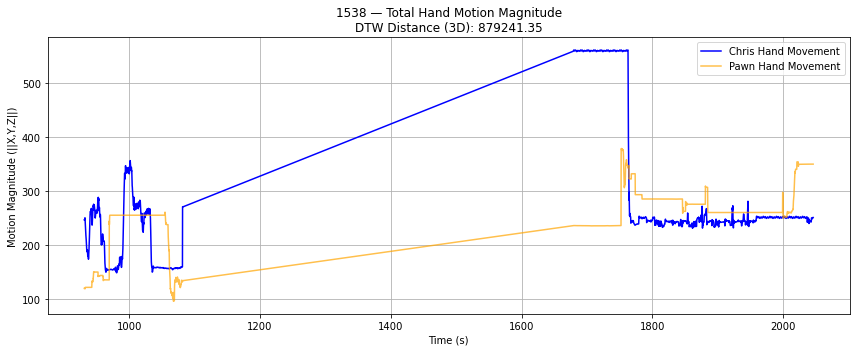

In [28]:
# Compute 3D motion magnitude
merged["chris_magnitude"] = np.linalg.norm(
    merged[["position_x_chris", "position_y_chris", "position_z_chris"]].values, axis=1
)
merged["pawn_magnitude"] = np.linalg.norm(
    merged[["position_x_pawn", "position_y_pawn", "position_z_pawn"]].values, axis=1
)

# Line plot of magnitude
plt.figure(figsize=(12, 5))
plt.plot(merged["time"], merged["chris_magnitude"], label="Chris Hand Movement", color="blue")
plt.plot(merged["time"], merged["pawn_magnitude"], label="Pawn Hand Movement", color="orange", alpha=0.7)

plt.title(f"{PARTICIPANT_ID} — Total Hand Motion Magnitude\nDTW Distance (3D): {dtw_distance:.2f}")
plt.xlabel("Time (s)")
plt.ylabel("Motion Magnitude (||X,Y,Z||)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"{PARTICIPANT_ID}_WristRight_DTW_MagnitudePlot.png"), dpi=300)
plt.show()


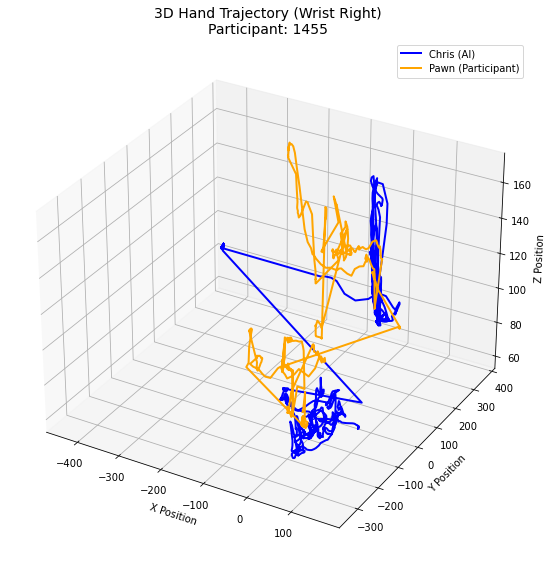

✅ Plot saved to: C:\Users\bmoha\Desktop\DataCollection\Lisbon\hand_trajectory_plots\1455_3d_hand_trajectory.png


In [23]:

import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# === CONFIG ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# === CONFIG ===
root_path = r"C:\Users\bmoha\Desktop\DataCollection\Dublin"  # or Lisbon, depending on the participant

PARTICIPANT_ID = "1538"  # Change this to any specific participant
HAND = "WristRight"
OUTPUT_DIR = os.path.join(ROOT, "hand_dtw_motion")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def extract_char_id(aname):
    return "_".join(aname.split("_")[:3])

# === Load Data ===
def load_participant_data(pid):
    for group in os.listdir(ROOT):
        group_path = os.path.join(ROOT, group)
        if not os.path.isdir(group_path):
            continue
        participant_path = os.path.join(group_path, pid)
        heat_logs_path = os.path.join(participant_path, "heat_logs")
        if not os.path.exists(heat_logs_path):
            continue

        dfs = []
        for session in os.listdir(heat_logs_path):
            session_path = os.path.join(heat_logs_path, session)
            if not os.path.isdir(session_path):
                continue
            for file in os.listdir(session_path):
                if file.endswith(".csv"):
                    try:
                        df = pd.read_csv(os.path.join(session_path, file))
                        dfs.append(df)
                    except:
                        continue
        if dfs:
            return pd.concat(dfs, ignore_index=True)
    return None

# === Load + Preprocess ===
df = load_participant_data(PARTICIPANT_ID)
if df is None:
    print(f"❌ No data found for {PARTICIPANT_ID}")
    exit()

# === Helper: Extract character info ===
def extract_character_id(aname):
    return "_".join(aname.split("_")[:3])

# === Load all CSVs from heat_logs ===
def load_participant_data(pid):
    heat_log_dir = os.path.join(root_path, pid, "heat_logs")
    all_dfs = []
    if not os.path.exists(heat_log_dir):
        print(f"No heat_logs for {pid}")
        return None

    for session in os.listdir(heat_log_dir):
        session_path = os.path.join(heat_log_dir, session)
        if not os.path.isdir(session_path):
            continue
        for file in os.listdir(session_path):
            if file.endswith(".csv"):
                fpath = os.path.join(session_path, file)
                try:
                    df = pd.read_csv(fpath)
                    all_dfs.append(df)
                except Exception as e:
                    print(f"Failed to read {fpath}: {e}")
    if all_dfs:
        return pd.concat(all_dfs, ignore_index=True)
    return None

# === Load & preprocess data ===
full_df = load_participant_data(participant_id)
if full_df is None or full_df.empty:
    raise ValueError("No data found for participant.")

# Extract character info
full_df["char_id"] = full_df["Aname"].apply(extract_character_id)
full_df["body_part"] = full_df["Aname"].apply(lambda x: x.split("_")[-1])
characters = full_df["char_id"].unique()

if len(characters) < 2:
    raise ValueError("Not enough characters found.")

# Identify Chris and Pawn
char_chris = [c for c in characters if "Chris" in c or "BP_Chris" in c]
char_pawn = [c for c in characters if c not in char_chris]

if not char_chris or not char_pawn:
    raise ValueError("Could not identify Chris and Pawn.")

char_chris = char_chris[0]
char_pawn = char_pawn[0]

# Get WristRight data for both
def get_hand_data(df, char_id):
    return df[(df["char_id"] == char_id) & (df["body_part"] == "WristRight")][
        ["time", "position_x", "position_y", "position_z"]
    ].drop_duplicates("time").sort_values("time")

chris_df = get_hand_data(full_df, char_chris)
pawn_df = get_hand_data(full_df, char_pawn)

# Merge on time
merged = pd.merge(chris_df, pawn_df, on="time", suffixes=("_chris", "_pawn"))

# === Plot 3D trajectory ===
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    merged["position_x_chris"], merged["position_y_chris"], merged["position_z_chris"],
    label="Chris (AI)", color='blue', linewidth=2
)
ax.plot(
    merged["position_x_pawn"], merged["position_y_pawn"], merged["position_z_pawn"],
    label="Pawn (Participant)", color='orange', linewidth=2
)

# Aesthetics
ax.set_title(f"3D Hand Trajectory (Wrist Right)\nParticipant: {participant_id}", fontsize=14)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Z Position")
ax.legend()
ax.grid(True)

# Save
plot_path = os.path.join(output_dir, f"{participant_id}_3d_hand_trajectory.png")
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"✅ Plot saved to: {plot_path}")


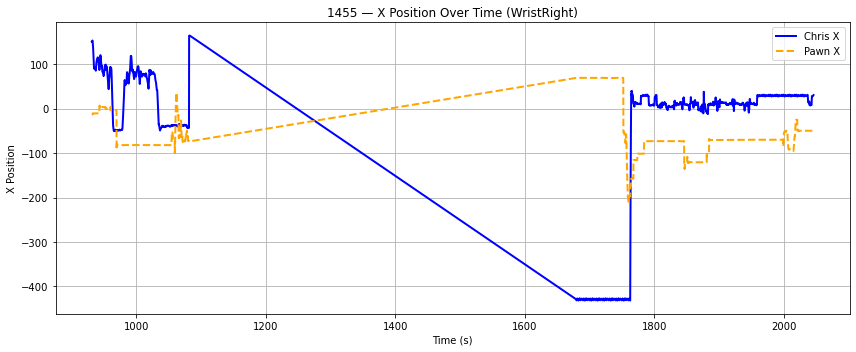

In [24]:
import matplotlib.pyplot as plt

# Merge on time (if not done)
merged = pd.merge(chris_df, pawn_df, on="time", suffixes=("_chris", "_pawn"))

# Plot X positions
plt.figure(figsize=(12, 5))
plt.plot(merged["time"], merged["position_x_chris"], label="Chris X", color="blue", linewidth=2)
plt.plot(merged["time"], merged["position_x_pawn"], label="Pawn X", color="orange", linestyle="--", linewidth=2)

plt.title(f"{participant_id} — X Position Over Time (WristRight)")
plt.xlabel("Time (s)")
plt.ylabel("X Position")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


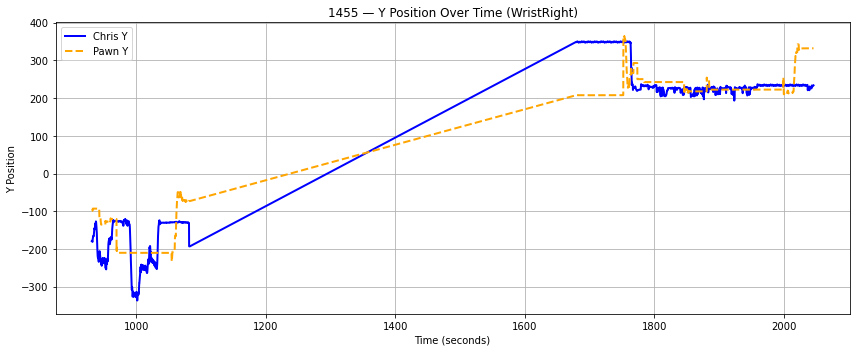

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Merge the Chris and Pawn dataframes on time
merged = pd.merge(chris_df, pawn_df, on="time", suffixes=("_chris", "_pawn"))

# ✅ Plot Y position over time
plt.figure(figsize=(12, 5))
plt.plot(merged["time"], merged["position_y_chris"], label="Chris Y", color="blue", linewidth=2)
plt.plot(merged["time"], merged["position_y_pawn"], label="Pawn Y", color="orange", linestyle="--", linewidth=2)

plt.title(f"{participant_id} — Y Position Over Time (WristRight)")
plt.xlabel("Time (seconds)")
plt.ylabel("Y Position")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


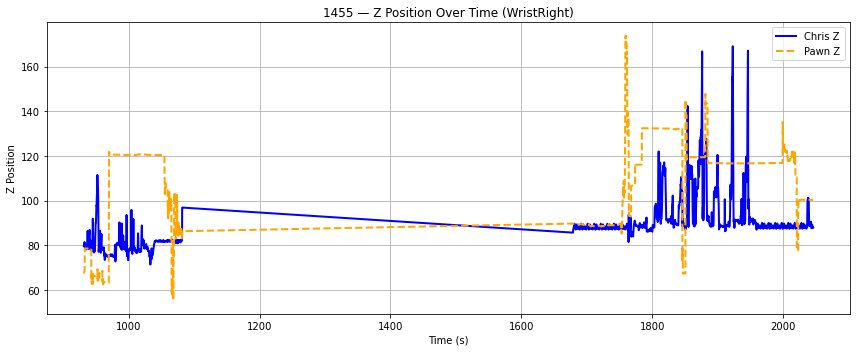

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Merge Chris and Pawn on time
merged = pd.merge(chris_df, pawn_df, on="time", suffixes=("_chris", "_pawn"))

# Plot Z position
plt.figure(figsize=(12, 5))
plt.plot(merged["time"], merged["position_z_chris"], label="Chris Z", color="blue", linewidth=2)
plt.plot(merged["time"], merged["position_z_pawn"], label="Pawn Z", color="orange", linestyle="--", linewidth=2)

plt.title(f"{participant_id} — Z Position Over Time (WristRight)")
plt.xlabel("Time (s)")
plt.ylabel("Z Position")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


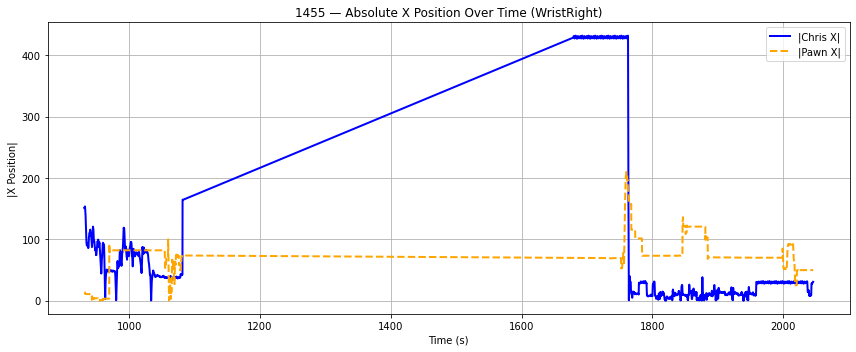

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Merge on time
merged = pd.merge(chris_df, pawn_df, on="time", suffixes=("_chris", "_pawn"))

# Plot absolute X position
plt.figure(figsize=(12, 5))
plt.plot(merged["time"], np.abs(merged["position_x_chris"]), label="|Chris X|", color="blue", linewidth=2)
plt.plot(merged["time"], np.abs(merged["position_x_pawn"]), label="|Pawn X|", color="orange", linestyle="--", linewidth=2)

plt.title(f"{participant_id} — Absolute X Position Over Time (WristRight)")
plt.xlabel("Time (s)")
plt.ylabel("|X Position|")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


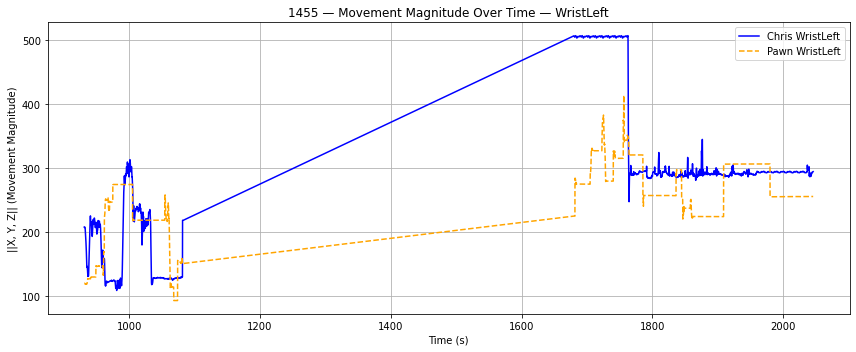

✅ Plot saved: C:\Users\bmoha\Desktop\DataCollection\Dublin\hand_magnitude_plots\1455_WristLeft_magnitude.png
✅ Data saved: C:\Users\bmoha\Desktop\DataCollection\Dublin\hand_magnitude_plots\1455_WristLeft_magnitude.csv


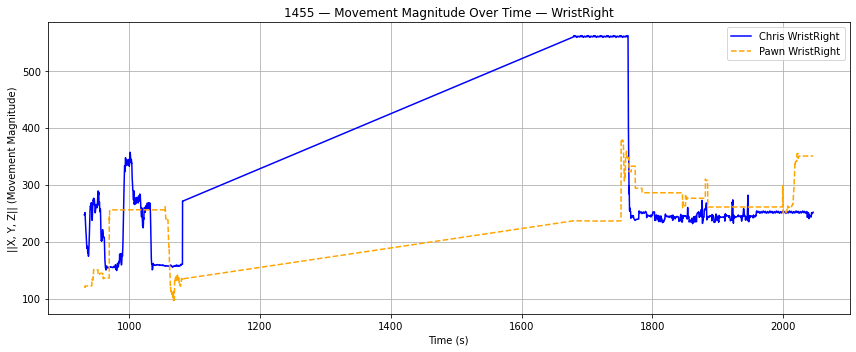

✅ Plot saved: C:\Users\bmoha\Desktop\DataCollection\Dublin\hand_magnitude_plots\1455_WristRight_magnitude.png
✅ Data saved: C:\Users\bmoha\Desktop\DataCollection\Dublin\hand_magnitude_plots\1455_WristRight_magnitude.csv


In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === CONFIG ===
participant_id = "1455"  # Replace with your participant folder name
root_path = r"C:\Users\bmoha\Desktop\DataCollection\Dublin"  # or "Lisbon" based on your data
output_dir = os.path.join(root_path, "hand_magnitude_plots")
os.makedirs(output_dir, exist_ok=True)

# === UTILITIES ===
def extract_character_id(aname):
    return "_".join(aname.split("_")[:3])

def load_participant_data(pid):
    heat_log_dir = os.path.join(root_path, pid, "heat_logs")
    all_dfs = []
    if not os.path.exists(heat_log_dir):
        print(f"❌ No heat_logs for {pid}")
        return None
    for session in os.listdir(heat_log_dir):
        session_path = os.path.join(heat_log_dir, session)
        if not os.path.isdir(session_path):
            continue
        for file in os.listdir(session_path):
            if file.endswith(".csv"):
                fpath = os.path.join(session_path, file)
                try:
                    df = pd.read_csv(fpath)
                    all_dfs.append(df)
                except Exception as e:
                    print(f"❌ Failed to read {fpath}: {e}")
    return pd.concat(all_dfs, ignore_index=True) if all_dfs else None

def get_hand_df(df, char_id, body_part):
    return df[(df["char_id"] == char_id) & (df["body_part"] == body_part)][
        ["time", "position_x", "position_y", "position_z"]
    ].drop_duplicates("time").sort_values("time")

def compute_magnitude(df, label):
    df[label] = np.linalg.norm(df[["position_x", "position_y", "position_z"]].values, axis=1)
    return df[["time", label]]

# === LOAD DATA ===
full_df = load_participant_data(participant_id)
if full_df is None or full_df.empty:
    raise ValueError("No data found for participant.")

# Extract character info
full_df["char_id"] = full_df["Aname"].apply(extract_character_id)
full_df["body_part"] = full_df["Aname"].apply(lambda x: x.split("_")[-1])
characters = full_df["char_id"].unique()

if len(characters) < 2:
    raise ValueError("Less than two characters found.")

# Identify Chris and Pawn
char_chris = [c for c in characters if "Chris" in c or "BP_Chris" in c]
char_pawn = [c for c in characters if c not in char_chris]

char_chris = char_chris[0]
char_pawn = char_pawn[0]

# === PROCESS EACH HAND ===
for body_part in ["WristLeft", "WristRight"]:
    # Get hand data
    df_chris = get_hand_df(full_df, char_chris, body_part)
    df_pawn = get_hand_df(full_df, char_pawn, body_part)

    # Compute magnitudes
    mag_chris = compute_magnitude(df_chris, "magnitude_chris")
    mag_pawn = compute_magnitude(df_pawn, "magnitude_pawn")

    # Merge on time
    merged = pd.merge(mag_chris, mag_pawn, on="time")

    # === PLOT ===
    plt.figure(figsize=(12, 5))
    plt.plot(merged["time"], merged["magnitude_chris"], label=f"Chris {body_part}", color="blue")
    plt.plot(merged["time"], merged["magnitude_pawn"], label=f"Pawn {body_part}", color="orange", linestyle="--")
    plt.title(f"{participant_id} — Movement Magnitude Over Time — {body_part}")
    plt.xlabel("Time (s)")
    plt.ylabel("||X, Y, Z|| (Movement Magnitude)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plot_path = os.path.join(output_dir, f"{participant_id}_{body_part}_magnitude.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()
    print(f"✅ Plot saved: {plot_path}")

    # === SAVE DATAFRAME WITH TIME + MAGNITUDE ===
    csv_out = os.path.join(output_dir, f"{participant_id}_{body_part}_magnitude.csv")
    merged.to_csv(csv_out, index=False)
    print(f"✅ Data saved: {csv_out}")


In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# === CONFIG ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"
GROUPS = ["Dublin", "Lisbon"]
HAND = "WristRight"
OUTPUT_DIR = os.path.join(ROOT, "hand_dtw_motion")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def extract_char_id(aname):
    return "_".join(aname.split("_")[:3])

def load_participant_data(group, pid):
    heat_logs_path = os.path.join(ROOT, group, pid, "heat_logs")
    dfs = []
    if not os.path.exists(heat_logs_path):
        return None
    for session in os.listdir(heat_logs_path):
        session_path = os.path.join(heat_logs_path, session)
        if not os.path.isdir(session_path):
            continue
        for file in os.listdir(session_path):
            if file.endswith(".csv"):
                try:
                    df = pd.read_csv(os.path.join(session_path, file))
                    dfs.append(df)
                except:
                    continue
    return pd.concat(dfs, ignore_index=True) if dfs else None

def extract_hand_trajectory(df, char_id, hand):
    d = df[(df["char_id"] == char_id) & (df["body_part"] == hand)]
    d = d[["time", "position_x", "position_y", "position_z"]].drop_duplicates("time").sort_values("time")
    return d

summary = []

# === MAIN LOOP ===
for group in GROUPS:
    group_path = os.path.join(ROOT, group)
    for pid in os.listdir(group_path):
        participant_path = os.path.join(group_path, pid)
        if not os.path.isdir(participant_path):
            continue

        print(f"🔍 Processing {group}/{pid}...")
        df = load_participant_data(group, pid)
        if df is None or df.empty:
            print(f"⚠️ No data for {group}/{pid}")
            continue

        if not {"time", "position_x", "position_y", "position_z", "Aname"}.issubset(df.columns):
            print(f"⚠️ Missing required columns for {group}/{pid}")
            continue

        df["char_id"] = df["Aname"].apply(extract_char_id)
        df["body_part"] = df["Aname"].apply(lambda x: x.split("_")[-1])
        char_ids = df["char_id"].unique()

        chris_ids = df[df["Aname"].str.contains("Chris")]["char_id"].unique()
        if len(chris_ids) == 0 or len(char_ids) < 2:
            print(f"⚠️ Could not find both Chris and Pawn in {group}/{pid}")
            continue

        char_chris = chris_ids[0]
        char_pawn = [c for c in char_ids if c != char_chris][0]

        df_chris = extract_hand_trajectory(df, char_chris, HAND)
        df_pawn = extract_hand_trajectory(df, char_pawn, HAND)

        merged = pd.merge(df_chris, df_pawn, on="time", suffixes=("_chris", "_pawn"))
        if merged.empty or len(merged) < 5:
            print(f"⚠️ No overlapping data or too few points for {group}/{pid}")
            continue

        chris_xyz = merged[["position_x_chris", "position_y_chris", "position_z_chris"]].values
        pawn_xyz = merged[["position_x_pawn", "position_y_pawn", "position_z_pawn"]].values

        try:
            dtw_distance, path = fastdtw(chris_xyz, pawn_xyz, dist=euclidean)
        except Exception as e:
            print(f"❌ DTW error for {group}/{pid}: {e}")
            continue

        # Compute magnitudes
        merged["chris_magnitude"] = np.linalg.norm(chris_xyz, axis=1)
        merged["pawn_magnitude"] = np.linalg.norm(pawn_xyz, axis=1)

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(merged["time"], merged["chris_magnitude"], label="Chris WristRight", color="blue")
        plt.plot(merged["time"], merged["pawn_magnitude"], label="Pawn WristRight", color="orange", alpha=0.7)
        plt.title(f"{group} {pid} — WristRight Motion Magnitude\nDTW Distance: {dtw_distance:.2f}")
        plt.xlabel("Time (s)")
        plt.ylabel("||X,Y,Z|| (Motion Magnitude)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plot_path = os.path.join(OUTPUT_DIR, f"{group}_{pid}_WristRight_DTW_Plot.png")
        plt.savefig(plot_path, dpi=300)
        plt.close()

        print(f"✅ DTW = {dtw_distance:.2f} | Plot saved: {plot_path}")

        # Save to summary
        summary.append({
            "Group": group,
            "Participant": pid,
            "BodyPart": HAND,
            "DTW_Distance": round(dtw_distance, 3)
        })

# === SAVE SUMMARY ===
summary_df = pd.DataFrame(summary)
csv_path = os.path.join(OUTPUT_DIR, f"wristright_dtw_summary.csv")
summary_df.to_csv(csv_path, index=False)
print(f"\n📄 Summary saved to: {csv_path}")


🔍 Processing Dublin/1455...
✅ DTW = 879241.35 | Plot saved: C:\Users\bmoha\Desktop\DataCollection\hand_dtw_motion\Dublin_1455_WristRight_DTW_Plot.png
🔍 Processing Dublin/1538...
✅ DTW = 815047.19 | Plot saved: C:\Users\bmoha\Desktop\DataCollection\hand_dtw_motion\Dublin_1538_WristRight_DTW_Plot.png
🔍 Processing Dublin/1626...
✅ DTW = 659894.01 | Plot saved: C:\Users\bmoha\Desktop\DataCollection\hand_dtw_motion\Dublin_1626_WristRight_DTW_Plot.png
🔍 Processing Dublin/1629...
✅ DTW = 1771915.99 | Plot saved: C:\Users\bmoha\Desktop\DataCollection\hand_dtw_motion\Dublin_1629_WristRight_DTW_Plot.png
🔍 Processing Dublin/1700...
✅ DTW = 1053918.56 | Plot saved: C:\Users\bmoha\Desktop\DataCollection\hand_dtw_motion\Dublin_1700_WristRight_DTW_Plot.png
🔍 Processing Dublin/1789...
✅ DTW = 679554.97 | Plot saved: C:\Users\bmoha\Desktop\DataCollection\hand_dtw_motion\Dublin_1789_WristRight_DTW_Plot.png
🔍 Processing Dublin/1818...
✅ DTW = 1681559.92 | Plot saved: C:\Users\bmoha\Desktop\DataCollection

✅ DTW = 901949.02 | Plot saved: C:\Users\bmoha\Desktop\DataCollection\hand_dtw_motion\Lisbon_9084_WristRight_DTW_Plot.png
🔍 Processing Lisbon/9345...
✅ DTW = 396689.76 | Plot saved: C:\Users\bmoha\Desktop\DataCollection\hand_dtw_motion\Lisbon_9345_WristRight_DTW_Plot.png
🔍 Processing Lisbon/9383...
✅ DTW = 327086.41 | Plot saved: C:\Users\bmoha\Desktop\DataCollection\hand_dtw_motion\Lisbon_9383_WristRight_DTW_Plot.png
🔍 Processing Lisbon/hand_trajectory_plots...
⚠️ No data for Lisbon/hand_trajectory_plots

📄 Summary saved to: C:\Users\bmoha\Desktop\DataCollection\hand_dtw_motion\wristright_dtw_summary.csv


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# === CONFIG ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"
OUTPUT_DIR = os.path.join(ROOT, "location_heatmaps_3d_tot")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def extract_character_id(aname):
    return "_".join(aname.split("_")[:3])

def get_all_participants(data_root):
    all_participants = {}
    for location in os.listdir(data_root):
        loc_path = os.path.join(data_root, location)
        if not os.path.isdir(loc_path): continue
        for pid in os.listdir(loc_path):
            full_path = os.path.join(loc_path, pid, "heat_logs")
            if os.path.exists(full_path):
                all_participants[f"{location}_{pid}"] = full_path
    return all_participants

def plot_3d_heatmap(df, pid):
    if df.shape[0] < 5:
        print(f"⚠️ Skipping {pid}: not enough data points for KDE.")
        return

    x = df['position_x']
    y = df['position_y']
    
    # Stack and check unique values
    xy = np.vstack([x, y])
    if np.unique(xy, axis=1).shape[1] < 5:
        print(f"⚠️ Skipping {pid}: not enough unique positions.")
        return

    # Compute KDE
    density = gaussian_kde(xy)(xy)

    # === PLOT ===
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(x, y, density, cmap='plasma', linewidth=0.1, antialiased=True)

    ax.set_title(f"3D Location Density — {pid}", fontsize=14)
    ax.set_xlabel("Position X")
    ax.set_ylabel("Position Y")
    ax.set_zlabel("Density")
    plt.tight_layout()

    out_path = os.path.join(OUTPUT_DIR, f"{pid}_3d_location.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"✅ 3D heatmap saved: {out_path}")

# === MAIN SCRIPT ===
print("📦 Scanning participants for 3D heatmaps...")
participants = get_all_participants(ROOT)
all_dfs = []

for pid, heat_path in participants.items():
    print(f"📊 Processing {pid}...")
    dfs = []

    for session in os.listdir(heat_path):
        session_path = os.path.join(heat_path, session)
        if not os.path.isdir(session_path): continue

        for f in os.listdir(session_path):
            if not f.endswith(".csv"): continue
            try:
                df = pd.read_csv(os.path.join(session_path, f))
                if {"position_x", "position_y", "Aname"}.issubset(df.columns):
                    df = df[df["Aname"].str.contains("Pawn")]
                    dfs.append(df[["position_x", "position_y"]])
            except Exception as e:
                print(f"❌ Error reading {f}: {e}")

    if dfs:
        combined = pd.concat(dfs, ignore_index=True).dropna()
        all_dfs.append(combined)
        plot_3d_heatmap(combined, pid)

# === Global Plot ===
if all_dfs:
    full_df = pd.concat(all_dfs, ignore_index=True).dropna()
    plot_3d_heatmap(full_df, "All_Participants")

print(f"\n✅ All heatmaps saved to: {OUTPUT_DIR}")


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D

# === CONFIG ===
ROOT = r"C:\Users\bmoha\Desktop\DataCollection"
OUTPUT_DIR = os.path.join(ROOT, "location_heatmaps_3d_total1")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def extract_character_id(aname):
    return "_".join(aname.split("_")[:3])

def get_all_participants(data_root):
    all_participants = {}
    for location in os.listdir(data_root):
        loc_path = os.path.join(data_root, location)
        if not os.path.isdir(loc_path): continue
        for pid in os.listdir(loc_path):
            full_path = os.path.join(loc_path, pid, "heat_logs")
            if os.path.exists(full_path):
                all_participants[f"{location}_{pid}"] = full_path
    return all_participants

# === Plot Function ===
def plot_3d_heatmap(df, pid, out_dir):
    x = df["position_x"]
    y = df["position_y"]

    if len(x.unique()) < 2 or len(y.unique()) < 2:
        print(f"⚠️ Skipping {pid}: not enough unique X/Y values.")
        return False

    try:
        xy = np.vstack([x, y])
        density = gaussian_kde(xy)(xy)

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_trisurf(x, y, density, cmap='plasma', linewidth=0.2, antialiased=True)
        ax.set_title(f"3D Location Density — {pid}", fontsize=14)
        ax.set_xlabel("Position X")
        ax.set_ylabel("Position Y")
        ax.set_zlabel("Density")
        plt.tight_layout()

        out_path = os.path.join(out_dir, f"{pid}_3d_location.png")
        plt.savefig(out_path, dpi=300)
        plt.close()
        print(f"✅ Saved 3D heatmap: {out_path}")
        return True

    except Exception as e:
        print(f"❌ Error plotting {pid}: {e}")
        return False

# === MAIN ===
print("📦 Scanning participants for 3D heatmaps...")
participants = get_all_participants(ROOT)
all_dfs = []
saved = 0
skipped = 0

for pid, heat_path in participants.items():
    print(f"📊 Processing {pid}...")
    dfs = []

    for session in os.listdir(heat_path):
        session_path = os.path.join(heat_path, session)
        if not os.path.isdir(session_path):
            continue

        for f in os.listdir(session_path):
            if not f.endswith(".csv"): continue
            try:
                df = pd.read_csv(os.path.join(session_path, f))
                if {"position_x", "position_y", "Aname"}.issubset(df.columns):
                    df = df[df["Aname"].str.contains("Pawn")]
                    dfs.append(df[["position_x", "position_y"]])
            except Exception as e:
                print(f"❌ Error reading {f}: {e}")

    if dfs:
        combined = pd.concat(dfs, ignore_index=True).dropna()
        if plot_3d_heatmap(combined, pid, OUTPUT_DIR):
            all_dfs.append(combined)
            saved += 1
        else:
            skipped += 1
    else:
        print(f"⚠️ Skipping {pid}: No valid CSVs found.")
        skipped += 1

# === Global heatmap ===
print("\n📊 Processing All Participants...")
if all_dfs:
    global_df = pd.concat(all_dfs, ignore_index=True).dropna()
    if plot_3d_heatmap(global_df, "All_Participants", OUTPUT_DIR):
        print("✅ Global heatmap saved.")
    else:
        print("⚠️ Global heatmap failed.")
else:
    print("⚠️ No data collected for global heatmap.")

# === Summary ===
print(f"\n✅ Finished: {saved} heatmaps saved, {skipped} skipped.")
print(f"📁 Output folder: {OUTPUT_DIR}")
